# Exploring Popular Image Augmentation Libraries with MAITE

This is a simple notebook exploring the current state of popular image augmentation libraries. Additionally, the usability of the Augmentation protocol from MAITE will be considered.

## Table Of Contents

* [Environment Setup](#environment-setup)
* [Initial Image and Detections](#init-image-and-detections)
* [Albumentations](#albumentations)
  * [ReplayCompose](#replaycompose)
* [AugLy](#augly)
* [imgaug](#imgaug)
* [Kornia](#kornia)
* [Torchvision Transforms](#torchvision-transforms)

## Environment Setup <a name="environment-setup"></a>

In [ ]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing augly...")
!{sys.executable} -m pip install -q augly[image]
print("Installing albumentations...")
!{sys.executable} -m pip install -q albumentations
print("Installing imgaug...")
!{sys.executable} -m pip install -q imgaug
print("Installing kornia...")
!{sys.executable} -m pip install -q kornia
print("Installing torch and torchvision...")
!{sys.executable} -m pip install -q "torch!=2.0.1" "torchvision==0.17"
print("Installing smqtk-detection...")
!{sys.executable} -m pip install -qU smqtk-detection[centernet]
# Remove opencv-python, which requires libGL, which we don't require here, and replace with opencv-python-headless
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
import os
import random
import urllib.request
from collections.abc import Hashable, Iterable, Iterator
from dataclasses import dataclass

import albumentations as a  # type: ignore
import augly.image as imaugs  # type: ignore
import imgaug.augmenters as iaa  # type: ignore
import imgaug.random  # type: ignore
import kornia as k  # type: ignore
import numpy as np
import torch  # type: ignore
from augly.image import aug_np_wrapper  # type: ignore
from imgaug.augmentables.bbs import BoundingBoxesOnImage  # type: ignore
from kornia.augmentation import AugmentationSequential  # type: ignore
from kornia.geometry.bbox import bbox_generator  # type: ignore
from matplotlib import pyplot as plt  # type: ignore
from matplotlib.axes import Axes  # type: ignore
from matplotlib.patches import Rectangle  # type: ignore
from PIL import Image
from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone
from smqtk_image_io.bbox import AxisAlignedBoundingBox
from torchvision import tv_tensors  # type: ignore
from torchvision.transforms import v2 as tv  # type: ignore

## Initial Image and Detections <a name="init-image-and-detections"></a>

We'll perform augmentations on a singular image from Visdrone and its detections from the SMQTK-implementation of the CenterNet model.

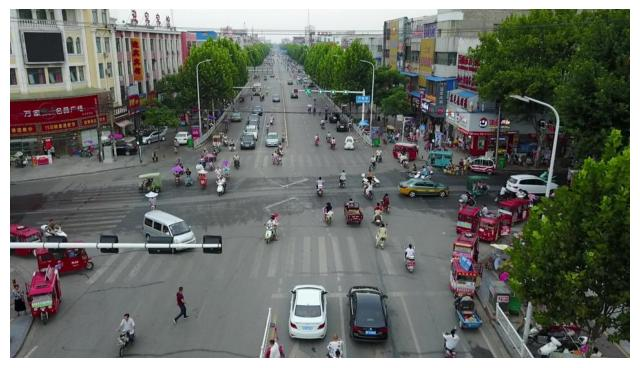

In [3]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download", img_path)

img = np.asarray(Image.open(img_path))

plt.figure(figsize=(8, 8))
plt.axis("off")
_ = plt.imshow(img)

In [ ]:
# download weights
model_file = os.path.join(data_dir, "centernet-resnet50.pth")
if not os.path.isfile(model_file):
    urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/623259f64acac99f426f21db/download", model_file)

center_net_detector = CenterNetVisdrone(
    arch="resnet50",
    model_file="data/centernet-resnet50.pth",
    max_dets=500,
    use_cuda=False,
    batch_size=1,
    num_workers=1,
)

Define a dataclass for detections that conforms to maite's [`ObjectDetectionTarget`](https://github.com/mit-ll-ai-technology/maite/blob/14b014850aff0e1715e1a60279d3eed1e1a74cfe/src/maite/_internals/protocols/object_detection.py#L27) protocol.

In [ ]:
@dataclass
class ObjectDetectionData:
    """Dataclass for object detction data."""

    boxes: np.ndarray
    labels: np.ndarray
    scores: np.ndarray

    def __iter__(self) -> Iterator[tuple[np.ndarray, np.ndarray, np.ndarray]]:
        """Return an iterator for object detection data."""
        self.n = 0
        return self

    def __next__(self) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Get next object detection data."""
        if self.n < len(self.boxes):
            self.n += 1
            return self.boxes[self.n - 1], self.labels[self.n - 1], self.scores[self.n - 1]
        raise StopIteration

We'll reformat our detections so they're in the format specified by the relevant MAITE protocols.

In [ ]:
def dets_to_maite(
    dets: Iterable[tuple[AxisAlignedBoundingBox, dict[Hashable, float]]],
    thresh: float = 0.4,
) -> ObjectDetectionData:
    """Convert detections to MAITE format."""
    boxes = []
    labels = []

    for box, probs in dets:
        box_out = box.min_vertex.tolist()
        box_out.extend(box.max_vertex.tolist())

        # Just keep the highest scored prediction
        cls_name = max(probs, key=lambda key: probs[key])
        if probs[cls_name] > thresh:
            cls_idx = list(probs.keys()).index(cls_name)

            boxes.append(box_out)
            labels.append(cls_idx)

    return ObjectDetectionData(
        boxes=np.asarray(boxes, dtype=float),
        labels=np.asarray(labels, dtype=int),
        scores=np.asarray([1] * len(labels), dtype=int),
    )

In [ ]:
dets = list(center_net_detector([img]))[0]
maite_detections = dets_to_maite(dets, thresh=0.4)

Here we define a helper function to display the (potentially augmented) images and detections.

In [ ]:
def display_img_with_dets(
    img: np.ndarray,
    maite_dets: ObjectDetectionData,
    descriptor: str,
    show_labels: bool = False,
) -> None:
    """Display img with maite detections."""

    def _show_dets(ax: Axes, dets: ObjectDetectionData) -> None:
        if len(dets.boxes) != len(dets.labels):
            print("WARNING: number of detections != number of labels provided")
        for bbox, lbl in zip(dets.boxes, dets.labels):
            x1 = bbox[0]
            y1 = bbox[1]
            x2 = bbox[2]
            y2 = bbox[3]
            ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"))

            if show_labels:
                ax.text(x1, y1 - 2, lbl, color="b", fontsize=8)

    _fig, axs = plt.subplots(figsize=(8, 8))
    axs.set_title(descriptor)
    axs.imshow(img)
    axs.axis("off")
    _show_dets(axs, maite_dets)

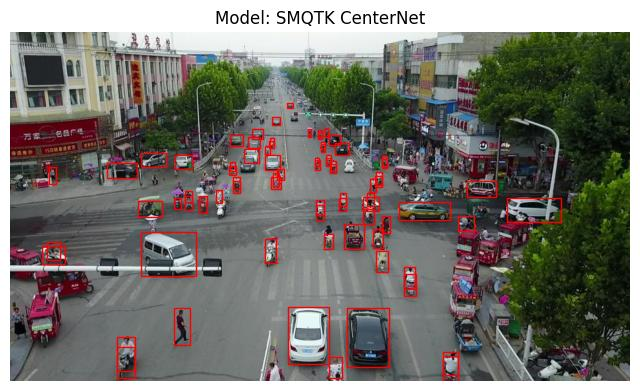

In [9]:
# Display initial images and detections
display_img_with_dets(img, maite_detections, "Model: SMQTK CenterNet")

Lastly, for reproducability, we'll define a function that seeds the various random number generators

In [ ]:
def seed_all(seed: int) -> None:
    """Set seeds for randomness."""
    random.seed(seed)
    np.random.default_rng(seed)
    imgaug.random.seed(seed)
    torch.manual_seed(seed)

## Albumentations <a name="albumentations"></a>

Throughout our exploration of these various augmentation tools, we will define a relatively simple pipeline, aiming to create similar pipelines across all tools. Additionally, we'll make sure each pipeline has some built-in randomness to determine the state of reproducability of each tool.

[Albumentations](https://github.com/albumentations-team/albumentations) is able to simultaneously transform multiple targets, so in addition to transforming our image we can easily transform our [bounding boxes](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), with support for multiple bounding box formats.

Some discussion of Albumentations reproducability can be found [here](https://albumentations.ai/docs/examples/serialization/).

It's also possible to integrate Albumentations with [PyTorch Transforms](https://albumentations.ai/docs/examples/pytorch_classification/) or [Tensorflow](https://albumentations.ai/docs/examples/tensorflow-example/).

Albumentations works with NumPy arrays.

In [ ]:
def alb_augmentation(img: np.ndarray, maite_dets: ObjectDetectionData) -> tuple[np.ndarray, ObjectDetectionData]:
    """Perform albumentations augmentations on input img."""
    image = img
    bboxes = maite_dets.boxes
    labels = maite_dets.labels

    augmentation_pipeline = a.Compose(
        [a.HorizontalFlip(p=0.5), a.VerticalFlip(p=0.5), a.RandomBrightnessContrast(p=0.8, contrast_limit=0.4)],
        bbox_params=a.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
    )

    out = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=labels)

    out_img, out_dets = (
        out["image"],
        ObjectDetectionData(
            boxes=out["bboxes"],
            labels=out["class_labels"],
            scores=np.asarray([1] * len(out["class_labels"]), dtype=int),
        ),
    )

    return out_img, out_dets

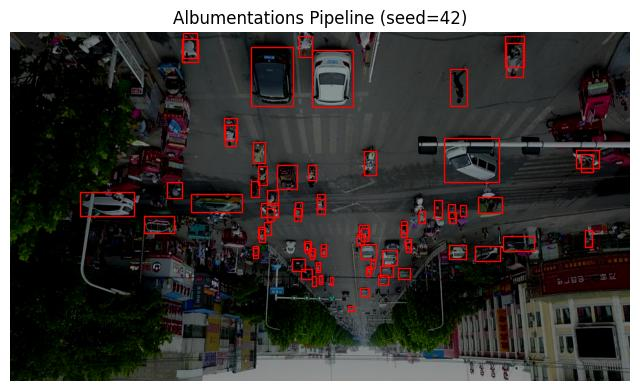

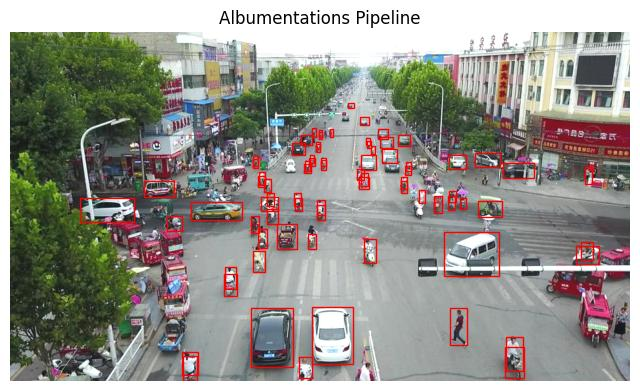

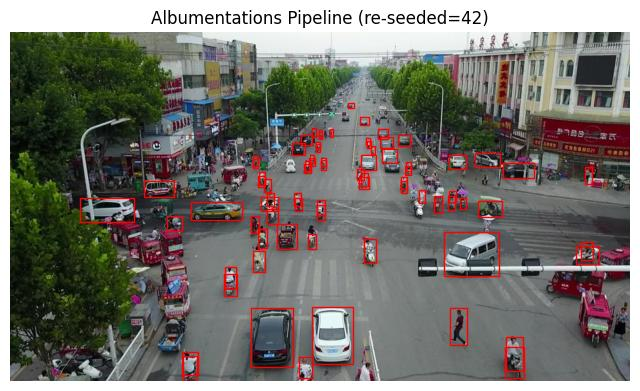

In [12]:
seed = 42

seed_all(seed)
out_img_1, out_dets_1 = alb_augmentation(img, maite_detections)
display_img_with_dets(out_img_1, out_dets_1, f"Albumentations Pipeline (seed={seed})")

out_img_2, out_dets_2 = alb_augmentation(img, maite_detections)
display_img_with_dets(out_img_2, out_dets_2, "Albumentations Pipeline")

seed_all(seed)
out_img_3, out_dets_3 = alb_augmentation(img, maite_detections)
display_img_with_dets(out_img_3, out_dets_3, f"Albumentations Pipeline (re-seeded={seed})")

### ReplayCompose <a name="replaycompose"></a>

[ReplayCompose](https://albumentations.ai/docs/examples/replay/) is a tool from Albumentations that tracks augmentation parameters to reapply them to another image. Albumentations presents this as one way to apply the same parameters to multiple images, bounding boxes, etc. This usage might be a bit trickier to conform to the `Augmentation` protocol, but the tool might be useful for certain workflows.

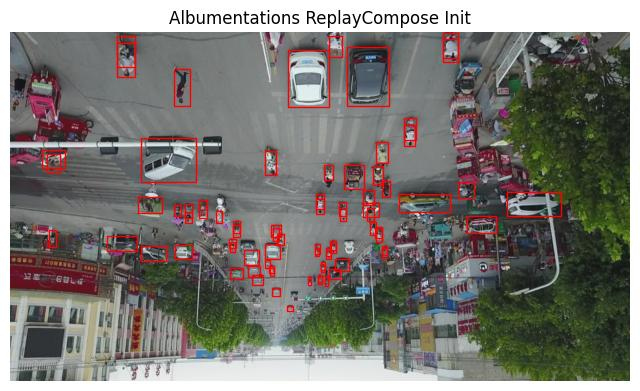

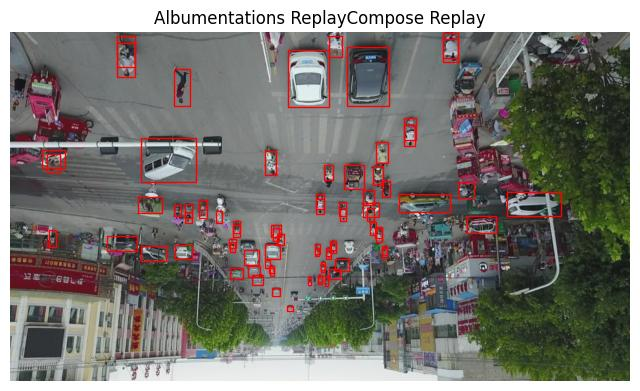

In [13]:
replay_pipeline = a.ReplayCompose(
    [a.HorizontalFlip(p=0.5), a.VerticalFlip(p=0.5), a.RandomBrightnessContrast(p=0.8, contrast_limit=0.4)],
    bbox_params=a.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
)

image = img
bboxes = maite_detections.boxes
labels = maite_detections.labels

replay_out = replay_pipeline(image=image, bboxes=bboxes, class_labels=labels)
replay_out_img_1, replay_out_dets_1 = (
    replay_out["image"],
    ObjectDetectionData(
        boxes=replay_out["bboxes"],
        labels=replay_out["class_labels"],
        scores=np.asarray([1] * len(replay_out["class_labels"]), dtype=int),
    ),
)
tmp = a.ReplayCompose.replay(replay_out["replay"], image=image, bboxes=bboxes, class_labels=labels)
replay_out_img_2, replay_out_dets_2 = (
    tmp["image"],
    ObjectDetectionData(
        boxes=tmp["bboxes"],
        labels=tmp["class_labels"],
        scores=np.asarray([1] * len(tmp["class_labels"]), dtype=int),
    ),
)

display_img_with_dets(replay_out_img_1, replay_out_dets_1, "Albumentations ReplayCompose Init")
display_img_with_dets(replay_out_img_2, replay_out_dets_2, "Albumentations ReplayCompose Replay")

# Images should be the same
replay_image1 = replay_out_img_1
replay_image2 = replay_out_img_2

## AugLy <a name="augly"></a>

Like Albumentations, [AugLy](https://github.com/facebookresearch/AugLy) can integrate with [PyTorch transformations](https://augly.readthedocs.io/en/latest/README_image.html#class-based).

AugLy can also preserve [bounding box information](https://augly.readthedocs.io/en/latest/README_image.html#augmenting-structured-data) (multiple bbox formats supported).

AugLy expects a PIL image as input but provides `aug_np_wrapper` which converts the numpy array to a PIL image and then calls the augmentation.

The optional `metadata` argument seems to provide enough information that it would be possible to re-construct the applied augmentation, but it's not necessarily straightforward to reapply that same augmentation.

In [ ]:
def augly_augmentation(img: np.ndarray, maite_dets: ObjectDetectionData) -> tuple[np.ndarray, ObjectDetectionData]:
    """Perform augly augmentations on input img."""
    image = img
    bboxes = maite_dets.boxes
    labels = maite_dets.labels

    if not isinstance(image, np.ndarray):
        raise ValueError("image is not of type np.ndarray")

    augmentation_pipeline = imaugs.Compose(
        [imaugs.HFlip(), imaugs.VFlip(), imaugs.RandomBrightness(min_factor=0.2, max_factor=2.0, p=0.5)],
    )

    meta = []
    out = aug_np_wrapper(
        image,
        augmentation_pipeline,  # type: ignore
        bboxes=bboxes,
        bbox_format="pascal_voc",
        metadata=meta,
    )

    out_img, out_dets = (
        out,
        ObjectDetectionData(
            boxes=np.asarray(meta[-1]["dst_bboxes"], dtype=float),
            labels=labels,
            scores=np.ones(labels.size),  # type: ignore
        ),
    )

    return out_img, out_dets

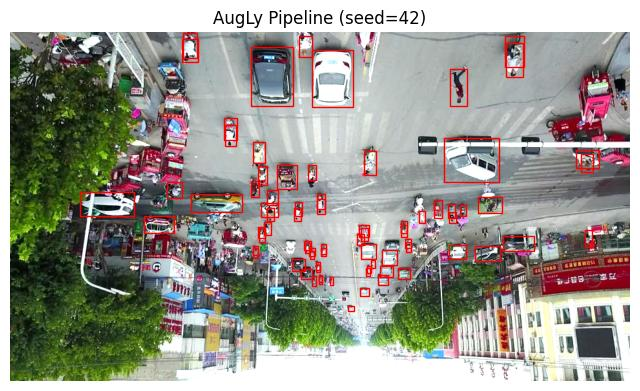

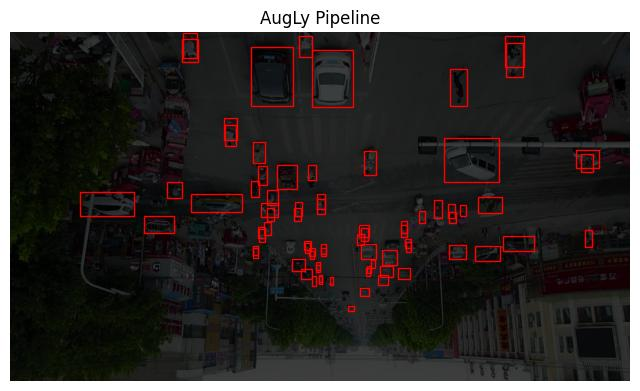

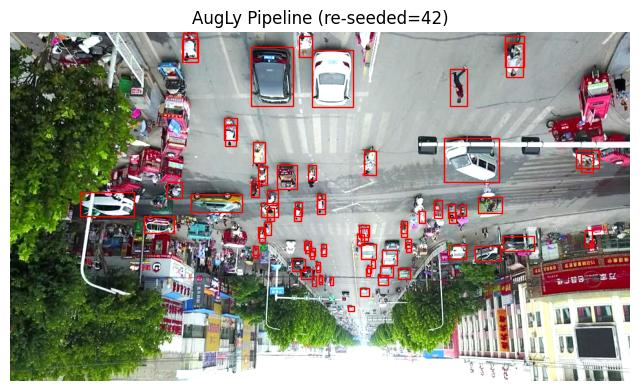

In [15]:
seed = 42

seed_all(seed)
augly_out_1, augly_dets_1 = augly_augmentation(img, maite_detections)
display_img_with_dets(augly_out_1, augly_dets_1, f"AugLy Pipeline (seed={seed})")

augly_out_2, augly_dets_2 = augly_augmentation(img, maite_detections)
display_img_with_dets(augly_out_2, augly_dets_2, "AugLy Pipeline")

seed_all(seed)
augly_out_3, augly_dets_3 = augly_augmentation(img, maite_detections)
display_img_with_dets(augly_out_3, augly_dets_3, f"AugLy Pipeline (re-seeded={seed})")

## imgaug <a name="imgaug"></a>

Note: at least some of imgaug transforms seem to be available via [Albumentations](https://albumentations.ai/docs/api_reference/imgaug/transforms/)

While [imgaug](https://github.com/aleju/imgaug) is able to support transforming related data such as bounding boxes, bounding boxes are restricted to one format.

imgaug is able to support computing (CPU) batches of augmentations including on [multiple cores](https://nbviewer.org/github/aleju/imgaug-doc/blob/master/notebooks/A03%20-%20Multicore%20Augmentation.ipynb).

The documentation contains a section discussing the use of [stochastic parameters](https://imgaug.readthedocs.io/en/latest/source/parameters.html) as a means to determinism.

NumPy is the supported data format.

In [ ]:
def imgaug_augmentation(img: np.ndarray, maite_dets: ObjectDetectionData) -> tuple[np.ndarray, ObjectDetectionData]:
    """Perform imgaug augmentations on input img."""
    image = img
    bboxes = maite_dets.boxes
    labels = maite_dets.labels

    bbs = BoundingBoxesOnImage.from_xyxy_array(bboxes, shape=image.shape)  # type: ignore

    augmentation_seq = iaa.Sequential(
        [
            iaa.Fliplr(0.5),  # type: ignore
            iaa.Flipud(0.5),  # type: ignore
            iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30)),
        ],
    )

    img_aug, bbs_aug = augmentation_seq(  # type: ignore
        image=image,
        bounding_boxes=bbs,
    )

    bboxes_aug = bbs_aug.to_xyxy_array()

    out_img, out_dets = (
        img_aug,
        ObjectDetectionData(boxes=bboxes_aug, labels=labels, scores=np.ones(labels.size)),  # type: ignore
    )

    return out_img, out_dets

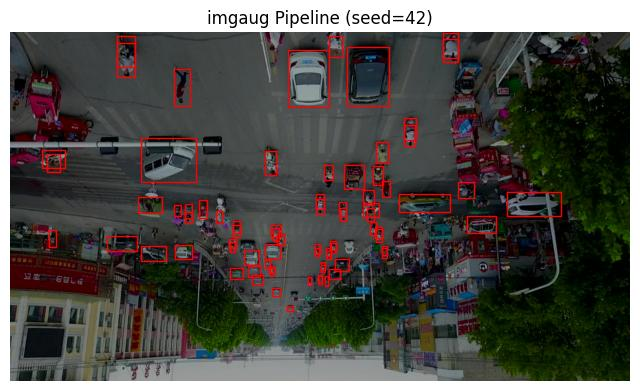

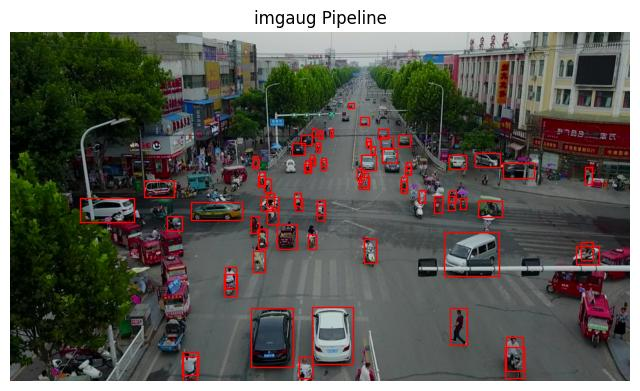

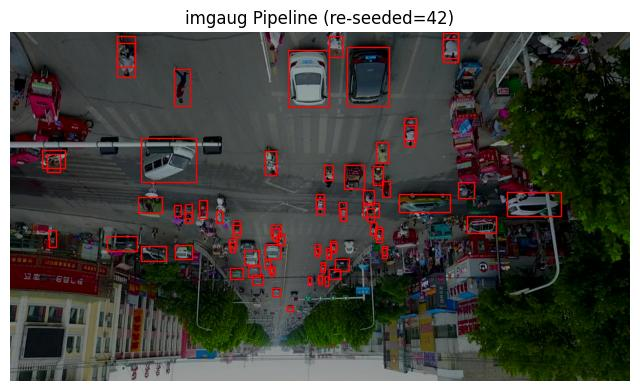

In [17]:
seed = 42

seed_all(seed)
imgaug_out_1, imgaug_dets_1 = imgaug_augmentation(img, maite_detections)
display_img_with_dets(imgaug_out_1, imgaug_dets_1, f"imgaug Pipeline (seed={seed})")

imgaug_out_2, imgaug_dets_2 = imgaug_augmentation(img, maite_detections)
display_img_with_dets(imgaug_out_2, imgaug_dets_2, "imgaug Pipeline")

seed_all(seed)
imgaug_out_3, imgaug_dets_3 = imgaug_augmentation(img, maite_detections)
display_img_with_dets(imgaug_out_3, imgaug_dets_3, f"imgaug Pipeline (re-seeded={seed})")

## Kornia <a name="kornia"></a>

[Kornia](https://github.com/rdevon/kornia) is able to transform bounding boxes. As a way to support rotational transforms, Kornia strongly prefers all 4 corners of the bbox as input. A function to transform from `x_min, y_min, width, height` is provided. Documentation on transforming bounding boxes and other truth objects is sparse.

Kornia is able to do batched, on-GPU transformations.

PyTorch tensors are the built-in data format of Kornia. Note the channel first format of Kornia augmentations. Kornia docs also frequently reference BGR vs RGB.

In [ ]:
def kornia_augmentation(img: np.ndarray, maite_dets: ObjectDetectionData) -> tuple[np.ndarray, ObjectDetectionData]:
    """Perform Kornia augmentations on input img."""

    def _to_kornia_bboxes(bboxes: np.ndarray) -> torch.Tensor:
        return bbox_generator(
            x_start=torch.Tensor(bboxes[:, 0]),
            y_start=torch.Tensor(bboxes[:, 1]),
            width=torch.Tensor(bboxes[:, 2] - bboxes[:, 0] + 1),
            height=torch.Tensor(bboxes[:, 3] - bboxes[:, 1] + 1),
        )

    def _from_kornia_bboxes(bboxes: torch.Tensor) -> np.ndarray:
        out_boxes = np.empty((0, 4))
        for box in bboxes.numpy():
            out_boxes = np.vstack((out_boxes, np.append(np.min(box, axis=0), np.max(box, axis=0))))
        return out_boxes

    bboxes = maite_dets.boxes
    labels = maite_dets.labels

    im = np.moveaxis(img, 2, 0)
    image = torch.as_tensor((im - np.min(im)) / (np.max(im) - np.min(im)), dtype=torch.float32)
    bboxes = _to_kornia_bboxes(np.array(bboxes))

    augmentation_seq = AugmentationSequential(
        k.augmentation.RandomHorizontalFlip(p=0.5),
        k.augmentation.RandomVerticalFlip(p=0.5),
        k.augmentation.RandomBrightness(brightness=(0.8, 1.2), clip_output=True, p=0.8),
        data_keys=["input", "bbox"],
    )

    out = augmentation_seq(image, bboxes)

    img_out = np.moveaxis((out[0][0].numpy() * 255).astype(int), 0, 2)
    bboxes_out = _from_kornia_bboxes(out[1])

    out_img, out_dets = (
        img_out,
        ObjectDetectionData(boxes=bboxes_out, labels=labels, scores=np.ones(labels.size)),  # type: ignore
    )

    return out_img, out_dets

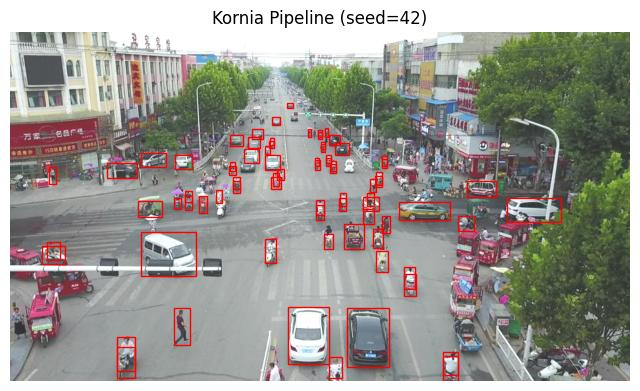

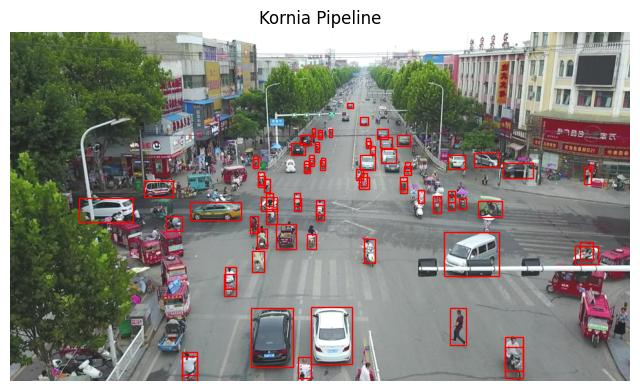

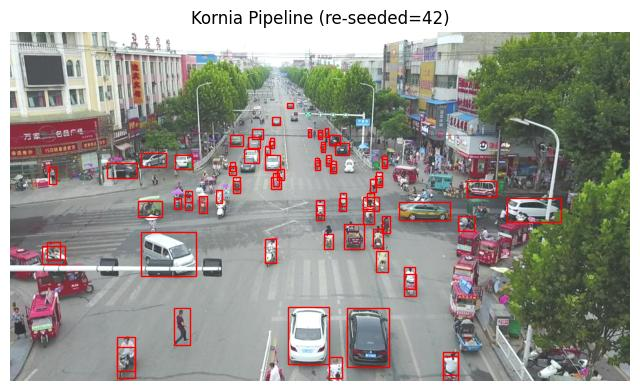

In [19]:
seed = 42

seed_all(seed)
kornia_img_out_1, kornia_dets_1 = kornia_augmentation(img, maite_detections)
display_img_with_dets(kornia_img_out_1, kornia_dets_1, f"Kornia Pipeline (seed={seed})")

kornia_img_out_2, kornia_dets_2 = kornia_augmentation(img, maite_detections)
display_img_with_dets(kornia_img_out_2, kornia_dets_2, "Kornia Pipeline")

seed_all(seed)
kornia_img_out_3, kornia_dets_3 = kornia_augmentation(img, maite_detections)
display_img_with_dets(kornia_img_out_3, kornia_dets_3, f"Kornia Pipeline (re-seeded={seed})")

## Torchvision Transforms v2 <a name="torchvision-transforms"></a>

Torchvision Transforms v1 does not have the capability to transform truth objects along with the image, but the v2 of the API aims to correct this issue. v2 is a drop-in replacement for v1. Note that the v2 of this API is still in beta.

On-GPU and batched transforms are possible with torchvision.

Many of torchvisions transforms expect PIL images as input.

In [ ]:
def torchvision_augmentation(
    img: np.ndarray,
    maite_dets: ObjectDetectionData,
) -> tuple[np.ndarray, ObjectDetectionData]:
    """Perform torchvision augmentations on input img."""
    bboxes = maite_dets.boxes
    labels = maite_dets.labels
    h, w, _ = np.shape(img)

    bbs = tv_tensors.BoundingBoxes(np.array(bboxes), format="XYXY", canvas_size=(h, w))  # type: ignore

    image = tv.functional.to_pil_image(img)

    augmentation_pipeline = tv.Compose(
        [
            tv.RandomHorizontalFlip(p=0.5),
            tv.RandomVerticalFlip(p=0.5),
            tv.ColorJitter(brightness=(0.5, 1.5), contrast=(1), saturation=(0.5, 1.5), hue=(-0.1, 0.1)),
        ],
    )

    img_aug, bbs_aug, labels_aug = augmentation_pipeline(image, bbs, labels)

    out_img, out_dets = (
        np.array(img_aug),
        ObjectDetectionData(boxes=bbs_aug, labels=labels_aug, scores=np.asarray([1] * len(labels_aug), dtype=int)),
    )

    return out_img, out_dets

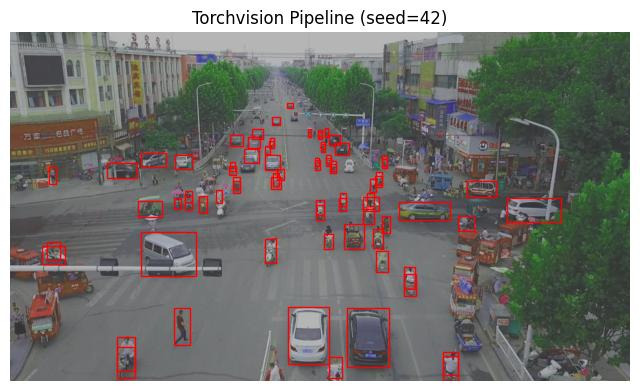

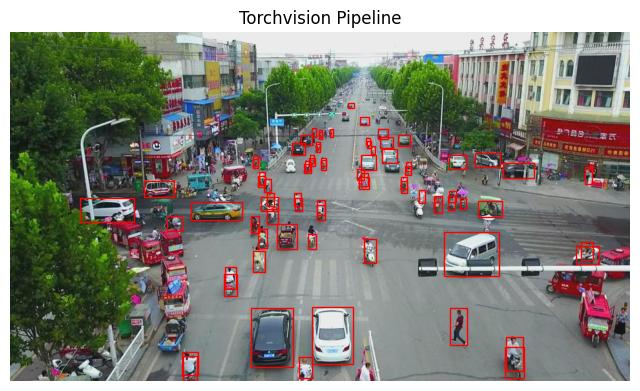

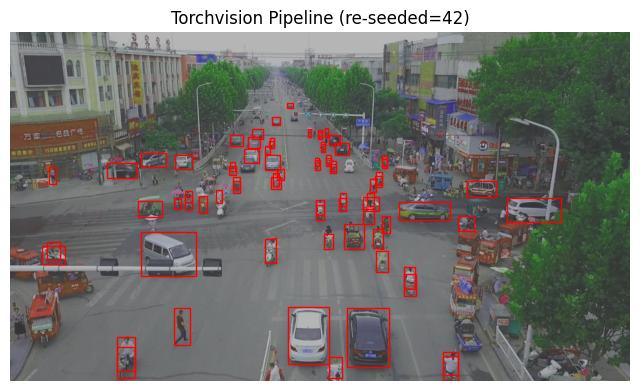

In [21]:
seed = 42

seed_all(seed)
torchvsion_img_out_1, torchvision_dets_1 = torchvision_augmentation(img, maite_detections)
display_img_with_dets(torchvsion_img_out_1, torchvision_dets_1, f"Torchvision Pipeline (seed={seed})")

torchvsion_img_out_2, torchvision_dets_2 = torchvision_augmentation(img, maite_detections)
display_img_with_dets(torchvsion_img_out_2, torchvision_dets_2, "Torchvision Pipeline")

seed_all(seed)
torchvsion_img_out_3, torchvision_dets_3 = torchvision_augmentation(img, maite_detections)
display_img_with_dets(torchvsion_img_out_3, torchvision_dets_3, f"Torchvision Pipeline (re-seeded={seed})")